
# Image Classification

In this lesson, we will build an image classifier to identify pet breeds. We’ll explore the key steps and techniques in the deep learning pipeline, from handling image data to transforming it, training models, and optimizing performance. We'll use the fastai library, which simplifies working with large datasets and neural networks.

In image classification, our goal is to assign a label $ y $ to each image $ X $ from a set of possible classes $ C $, where $ C $ could be categories like pet breeds, disease states, or cell types. Mathematically, we can represent this as a function $ f: X \rightarrow y $, which maps each image to a class label. This is achieved by training a model to minimize a loss function that quantifies the difference between predicted and true labels.

For binary classification (e.g., identifying the presence or absence of a disease), the output is a single probability score $ p $, with $ y = 1 $ if $ p \geq 0.5 $ and $ y = 0 $ otherwise. For multi-class classification (e.g., identifying different types of tumors), the model outputs a vector of probabilities $ \mathbf{p} = [p_1, p_2, \dots, p_k] $ for each class $ k $, where $ \sum_{i=1}^k p_i = 1 $.



##  Pet Breeds Data

We begin by importing fastai and downloading the Oxford-IIIT Pet dataset. This dataset consists of images of various pet breeds, making it suitable for building a model that classifies each image based on breed.


In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)


### Understanding Data Layout

To train a deep learning model effectively, we need to know how the data is structured. Generally, biomedical image data follows specific patterns, such as:

- **Folder-based organization:** Images are stored in directories by class label (e.g., “Normal” and “Tumor”).
- **Tabular annotation files:** Metadata in CSV files may specify the condition or label of each image.

Most datasets follow these patterns, though exceptions exist. For instance, genomic data may use binary database formats. Let’s explore the layout of our dataset:


In [2]:
path.ls()


(#2) [Path('C:/Users/biagi/.fastai/data/oxford-iiit-pet/annotations'),Path('C:/Users/biagi/.fastai/data/oxford-iiit-pet/images')]

In our case, pet images are stored in a directory, and the label (breed) is embedded in the filename.

The dataset contains two main folders: *images* and *annotations*. According to the dataset’s [website](https://www.robots.ox.ac.uk/~vgg/data/pets/), the *annotations* folder provides localization information (i.e., where pets are located in each image). For this lesson, we focus on classification (identifying the breed) rather than localization, so we’ll only use the *images* folder.



### Inspecting Image Files



To understand the data better, let’s examine the files inside the *images* directory.



In [3]:
(path/"images").ls()

(#7393) [Path('C:/Users/biagi/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),Path('C:/Users/biagi/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),Path('C:/Users/biagi/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),Path('C:/Users/biagi/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.mat'),Path('C:/Users/biagi/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),Path('C:/Users/biagi/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.mat'),Path('C:/Users/biagi/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg'),Path('C:/Users/biagi/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.mat'),Path('C:/Users/biagi/.fastai/data/oxford-iiit-pet/images/Abyssinian_103.jpg'),Path('C:/Users/biagi/.fastai/data/oxford-iiit-pet/images/Abyssinian_104.jpg')...]


Each filename contains the pet breed, followed by an underscore (`_`), a number, and a file extension. By analyzing the structure, we can see that the breed name precedes the underscore, making it possible to extract the breed name directly from the filename.



### Extracting Labels Using Regular Expressions

To automate label extraction, we can use regular expressions (regex). Regular expressions provide a powerful way to find patterns in text. Here, we’ll use regex to isolate the breed name from each filename.



In [4]:
import re

# Select an example file
fname = (path/"images").ls()[0]
# Use regex to extract the breed name
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Abyssinian']

Explanation:
- `r'(.+)_\d+.jpg$'`: This regex matches one or more characters before the last underscore, captures them in parentheses, and ignores the subsequent number and `.jpg` extension. This pattern helps us isolate the breed name in the filename.



### Building the DataBlock

With our extraction pattern in place, we’ll use fastai’s `DataBlock` API to set up the data pipeline. `DataBlock` helps you organize and transform data for training, providing a flexible approach to defining inputs, outputs, and transformations.



In [5]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)
dls = pets.dataloaders(path/"images")

#### Explanation of the `DataBlock` Parameters

- **`blocks=(ImageBlock, CategoryBlock)`**: Specifies that the input type is an image and the output is a category (label).
- **`get_items=get_image_files`**: Retrieves all image files within the specified path.
- **`splitter=RandomSplitter(seed=42)`**: Randomly splits the dataset into training and validation sets. Setting a seed ensures consistency across runs.
- **`get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name')`**: Uses the regex pattern to extract labels from filenames.
- **`item_tfms=Resize(460)`**: Resizes each image to 460 pixels. This larger size supports flexible transformations while preserving image quality.
- **`batch_tfms=aug_transforms(size=224, min_scale=0.75)`**: Performs batch-level transformations, such as resizing to 224 pixels and applying data augmentation.



##  Data Augmentation and Presizing

To improve model robustness, we’ll apply data augmentation using a technique called *presizing*. Presizing helps retain image quality during augmentation.



### Presizing

Presizing is an augmentation technique that prepares images at a larger size than the target training size. By resizing initially to 460 pixels, we avoid excessive data loss or distortion during transformations.

- **`item_tfms=Resize(460)`**: This transformation prepares images for subsequent augmentations by resizing them to a large dimension.
- **`batch_tfms=aug_transforms(size=224, min_scale=0.75)`**: The batch transformation downsizes images to the target size (224 pixels) and applies augmentations like rotation, zooming, and warping, ensuring these happen in a single step on the GPU to maintain data quality.

Presizing helps ensure that augmented images don’t lose essential details or develop artifacts, which can negatively impact model training.



##  Validating the Data Pipeline

Before training, always verify the data pipeline. Errors or misaligned labels can lead to incorrect model training. We can check the data layout using `show_batch`:



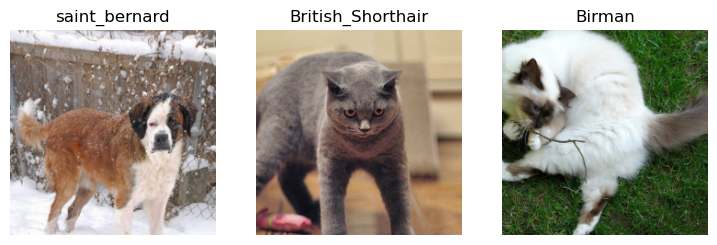

In [6]:
dls.show_batch(nrows=1, ncols=3)


This visualizes a batch of images and their labels, helping confirm that images match expected labels. If needed, use the `summary` method to display a detailed breakdown of data transformations and steps.


In [7]:
pets.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      C:\Users\biagi\.fastai\data\oxford-iiit-pet\images\saint_bernard_138.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      C:\Users\biagi\.fastai\data\oxford-iiit-pet\images\saint_bernard_138.jpg
    applying partial gives
      saint_bernard
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(30)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(30))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na':

##  Training the Model

Now that our data is ready, we can proceed to training. We’ll use a pretrained ResNet34 model from fastai’s vision library. This model will be fine-tuned for our specific task of classifying pet breeds.


In [15]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.646347,0.390989,0.127876,05:55


epoch,train_loss,valid_loss,error_rate,time
0,0.540573,0.316052,0.103518,07:15
1,0.381897,0.244374,0.077808,07:14


### Understanding Cross-Entropy Loss

In multi-class classification, the cross-entropy loss function, also known as log loss, is commonly used. For each image $ X $ with a true label $ y $, the loss is given by:

$$
\text{Loss} = - \sum_{i=1}^C y_i \log(p_i)
$$

where $ C $ is the number of classes, $ y_i $ is the true probability (0 or 1) for class $ i $, and $ p_i $ is the predicted probability for class $ i $. Cross-entropy encourages the model to output high probabilities for the correct class, penalizing incorrect predictions.


##  Interpreting the Model

After training, it’s helpful to interpret the model’s performance to understand areas of improvement. A confusion matrix is useful for identifying patterns in misclassifications.


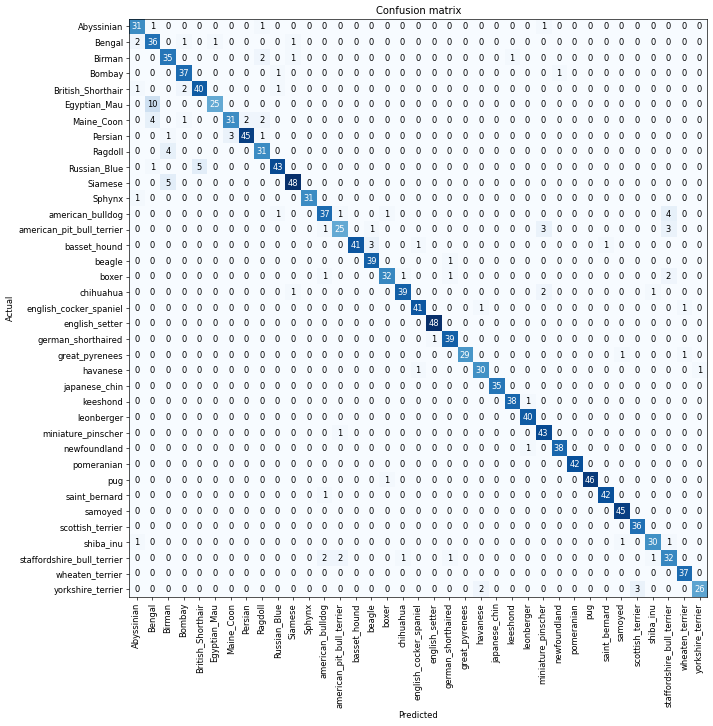

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)



When dealing with a large number of classes, as in this case with 37 breeds, the confusion matrix can become complex. The `most_confused` method highlights the most common errors:


In [17]:
interp.most_confused(min_val=5)


[('Egyptian_Mau', 'Bengal', 10),
 ('Russian_Blue', 'British_Shorthair', 5),
 ('Siamese', 'Birman', 5)]


This output shows which breeds the model often confuses, providing insights into areas needing improvement.



##  Improving the Model

### The Learning Rate

The learning rate $ \eta $ controls the step size in the gradient descent optimization process. At each training step, the model updates its weights $ w $ in the opposite direction of the gradient $ \nabla L(w) $ of the loss function $ L $ with respect to the weights. This update rule is:

$$
w_{i+1} = w_i - \eta \nabla L(w_i)
$$

If $ \eta $ is too large, the model may overshoot the optimal weights, causing unstable training. If $ \eta $ is too small, training may take too long to converge. The optimal learning rate is usually found by experimenting or using a learning rate finder.

### Learning Rate Finder

The learning rate finder in fastai allows us to identify a suitable learning rate by gradually increasing it and observing the effect on the loss. Here’s how to apply it:


c:\Users\biagi\anaconda3\envs\book\Lib\site-packages\fastai\learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torc

Minimum/10: 1.32e-05, steepest point: 6.31e-07


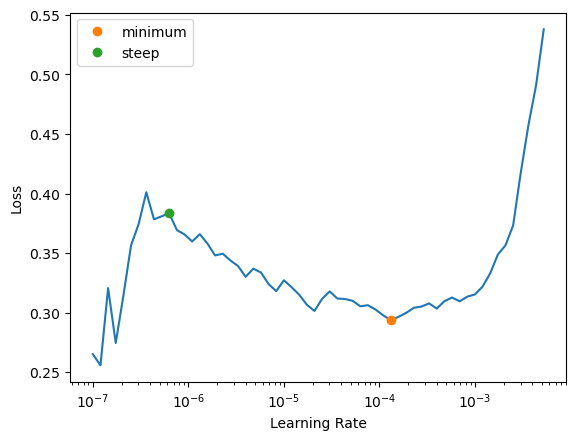

In [18]:
lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

> Note: Logarithmic Scale: The learning rate finder plot has a logarithmic scale, which is why the middle point between 1e-3 and 1e-2 is between 3e-3 and 4e-3. This is because we care mostly about the order of magnitude of the learning rate.


The learning rate plot helps identify a rate that minimizes loss without diverging. Choose a rate slightly lower than the minimum or steepest point, around 3e-3 in this case.




#  Fine-Tuning and Transfer Learning

### Concept of Transfer Learning

Transfer learning leverages a pretrained model on a related dataset to improve performance on a new task. For instance, in medical image analysis, a model pretrained on ImageNet might provide useful feature representations for a new dataset of MRI images. When fine-tuning, we typically:

 Freeze earlier layers to retain generic features like edge and shape detectors.
 Unfreeze later layers, allowing the model to adapt to specific features relevant to the new dataset.


In [19]:
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.284875,0.234757,0.075101,07:09
1,0.268512,0.227902,0.070365,07:12
2,0.269002,0.227186,0.071042,07:15
3,0.249046,0.223080,0.070365,07:20


Transfer learning is particularly useful in biomedical contexts where data can be scarce, such as in diagnosing rare diseases. Pretrained models on large datasets capture general image characteristics, while fine-tuning helps adapt the model to detect subtle differences relevant to the specific disease.


###  Discriminative Learning Rates

Different layers in a neural network can benefit from varied learning rates. Earlier layers, which capture more general features, should have lower rates, while later layers can use higher rates to adapt to the new task.


In [20]:
learn.fit_one_cycle(1, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.246748,0.224052,0.071719,07:29



### Using Deeper Architectures

Increasing model depth can help capture complex patterns. The ResNet architecture, used here in its 50-layer variant, is commonly used for image tasks. We’ll also use *mixed-precision training* for faster and more efficient processing.


In [21]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

c:\Users\biagi\anaconda3\envs\book\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\biagi\anaconda3\envs\book\Lib\site-packages\torch\amp\autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
c:\Users\biagi\anaconda3\envs\book\Lib\site-packages\fastai\callback\fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
c:\Users\biagi\anaconda3\envs\book\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,2.544297,0.550967,0.165765,08:47
1,0.908935,0.275755,0.095399,08:47
2,0.529911,0.263721,0.085927,08:48


epoch,train_loss,valid_loss,error_rate,time
0,0.356789,0.251893,0.079161,11:44
1,0.329284,0.285859,0.092693,12:05
2,0.286786,0.246736,0.075101,12:15
3,0.203805,0.232188,0.071042,12:47
4,0.134884,0.206825,0.063599,13:26
5,0.088163,0.196916,0.060217,14:49



In this example, mixed-precision training enables tensor cores on compatible GPUs, leading to faster training with less memory use.



### Further Optimization: Selecting Epochs and Avoiding Overfitting

Choosing the number of epochs is a balancing act. Too few epochs can result in underfitting, while too many can lead to overfitting. Here are some general guidelines:

- Start with a few epochs to see baseline performance.
- Monitor validation loss and accuracy over epochs to determine when the model starts overfitting.
- Use early stopping or cross-validation if needed.

If training resources allow, try experimenting with larger models or deeper architectures. However, always validate if additional complexity improves your specific task.